# Is Gun Violence an Epidemic?
By Daniel Hinman, Spring 2021

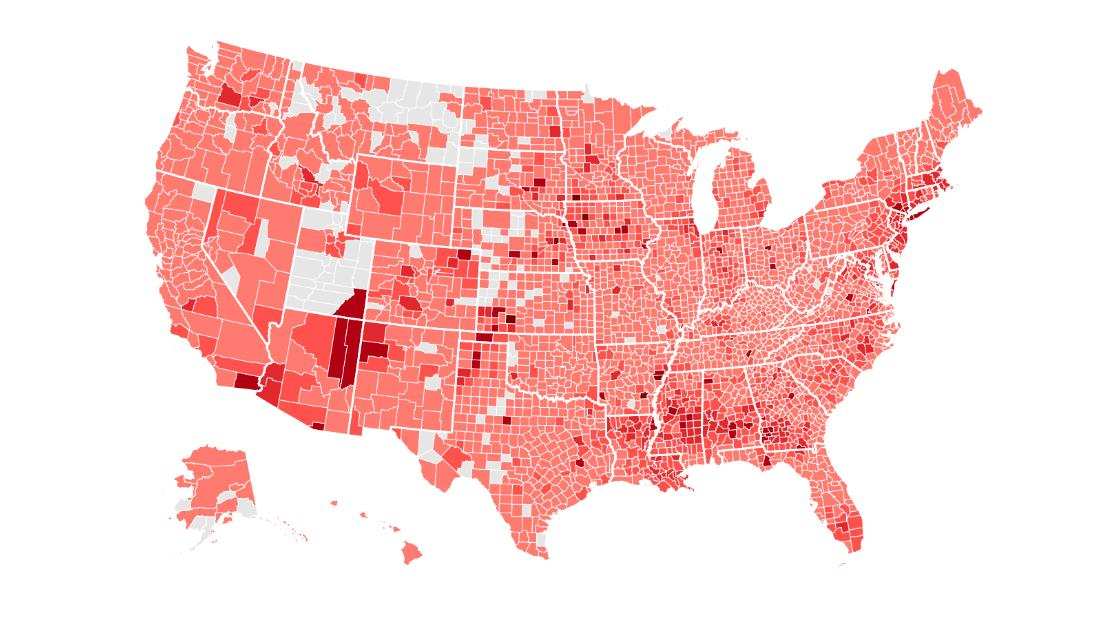

Photo retrieved from https://www.cnn.com/interactive/2020/health/coronavirus-us-maps-and-cases/


“{Gun violence} is an epidemic for God's sake” -Joe Biden

#### Introduction

President Biden recently made a comment that brings up an interesting question, is gun violence in America an epidemic? Obviously it is not a literal virus, but since we are currently living through a pandemic, it might be interesting to bring up some similarities and differences between COVID-19 and gun violence. Furthermore, the language our top politicians use matters. The onus is on them to describe situations accurately. The aim of this project is to ascertain whether or not gun violence is how our president describes, and to show you how easy it is to lie with statistics and graphs.

Going through this tutorial we are going to touch on using maps to display information, linear regression modeling, and some basic graph theory. However one of the most important topics is not the data itself, but how it is used. You should be able to walk away with a better understanding of how easy it is to manipulate data in a dishonest way, and what some of the signs are. 

Back to the question at hand, since that is extremely broad we must first narrow it down into smaller problems. 

1. What does the spread of the mass shootings look like in comparison to COVID-19? In other words, do the shootings tend to cluster around each other, or do they spread out evenly across the country?
2. The CDC defines an epidemic as a sudden increase in the number of cases in an area. With that, has the number of mass shootings increased drastically in the past 40 years, and has the number of firearm deaths increased drastically in the last 20 years?
3. What are the death rates of COVID-19 and firearms, and how do they compare?


Before answering these questions we need to classify what we mean by mass shooting. We define them as a public, intentional shooting with at least 4 or more fatalities. This is extremely similar to the definition the government uses. Classification is a major part of analysis, and we will go more into this later.

### Resources

Regex tester: https://regex101.com/

Interesting read on the subject of how mass shootings spread: https://www.rand.org/research/gun-policy/analysis/essays/mass-shootings.html

Intro to Gephi: https://libguides.brown.edu/gephi

Related graph theory: http://matthieu-totet.fr/Koumin/2013/12/16/understand-degree-weighted-degree-betweeness-centrality/#:~:text=Weighted%20Degree%20%3A%20Bigger%20is%20better,the%20weight%20of%20the%20edges.



## PART 1: DATA COLLECTION


For question 1 we must first get all of the locations and fatalities of the mass shootings from the first major one till the present. The Mother Jones database has many of the publicly disclosed mass shootings in the US since 1982, and the criteria bases a shooting to 3 or more fatalities. It does not contain every single shooting, no dataset is perfect and this one is no exception. First let's start by importing and installing some packages.

In [1]:
# You may see how the pip commands are commented out, that is because once you run them you do not have to run them
# again in the same environment, so you can just comment them out.
#!pip install nbconvert[webpdf]
#!pip install pyppeteer
#!pip install openpyxl
#!pip install requests
#!pip install folium
#!pip install html5lib
#!pip install haversine
import pandas as pd # For making dataframes, webscraping, and data analysis
import numpy as np # For special arrays and functions
import seaborn as sns # Graphing software with built in linear regression
import matplotlib.pyplot as plt # More graphing software
import folium # Used to visualize maps 
import requests # For webscraping
from folium.plugins import HeatMap as hm # For creating a heatmap for our folium maps


### MOTHER JONES DATABASE

The motivation for choosing this data set was that it fit the criteria that I had better than other datasets. It is much more strict on what classifies as a mass shooting compared to other data sets, with a similar definition to my own. Specifically, it dictates that a public shooting with at least 3 fatalities is a mass shooting. In order to get this dataframe to import correctly I had to download the xlsx file and fix one of the rows; data tables do not always play nice!

The location is the city and state of the shooting, fatalities is the number dead excluding the shooter himself. The rest is self explanatory, the unnamed columns do not tell us anything, so we will remove them in the next section.

Source: https://www.motherjones.com/politics/2012/12/mass-shootings-mother-jones-full-data/

In [2]:
# Pandas is used to create a dataframe, which you can think of as an excel table, but with more functionality
df = pd.read_excel('Mother Jones - Mass Shootings Database, 1982 - 2021.xlsx')
df.head()

,location,date,fatalities,injured,total_victims,age_of_shooter,latitude,longitude,year,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,"Indianapolis, Indiana",2021-04-15,8,7,15,19,39.686630,-86.323130,2021,NaN,NaN,NaN,NaN,NaN
1,"Orange, California",2021-03-31,4,1,5,-,33.835420,-117.853790,2021,NaN,NaN,NaN,NaN,NaN
2,"Boulder, Colorado",2021-03-22,10,0,10,21,39.986961,-105.251168,2021,NaN,NaN,NaN,NaN,NaN
3,"Atlanta, Georgia",2021-03-16,8,1,9,21,34.111653,-84.580376,2021,NaN,NaN,NaN,NaN,NaN
4,"Springfield, Missouri",2020-03-16,4,0,4,31,37.210432,-93.236860,2020,NaN,NaN,NaN,NaN,NaN


### COVID-19 SPREAD

Now we want to gather some data about COVID-19. While COVID-19 has been labeled as a pandemic according to the CDC, it can still be compared to an epidemic, with the main difference being that it is worldwide. The infection rates follow the same growth pattern as an epidemic. While the president did say 'epidemic' we have a lot of data on something that behaves very closely, so that is what I am using. We are going to look for the total infections and deaths per state in the US. This website updates the data weekly, and provides a succinct table for what we want.

We are not interested in the 7 day averages, so we are just going to look at the total number of deaths and cases for each state.

Source: https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

In [3]:
# Here I am just using pandas to read in an html request into a dataframe

url = 'https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/'
html = requests.get(url).content
# read html can read in the html we give it, and output the table we need
df_list = pd.read_html(html)

# The negative indexing makes it into a nice dataframe

covid_df = df_list[-1]
covid_df.head()

,State,7-day average cases,7-day average deaths,Cases,Deaths
0,AL,1298,9,539829,11038
1,AK,80,1,66683,347
2,AZ,657,8,872979,17466
3,AR,182,5,338687,5793
4,CA,1745,47,3664909,61499


### LATITUDE AND LONGITUDE OF EACH STATE

So we have data for each state, now we want the geocoordinates of each state so that we can plot points on a map. We are going to pull the data from a site and then tidy it up.

Source: https://www.latlong.net/category/states-236-14.html

In [4]:
# First lets get the lat and long of each state, we use the same method as before

url = 'https://www.latlong.net/category/states-236-14.html'
html = requests.get(url).content
locations = pd.read_html(html)
locations = locations[-1]
locations.head()

,Place Name,Latitude,Longitude
0,"Wisconsin, USA",44.5,-89.500000
1,"West Virginia, USA",39.0,-80.500000
2,"Vermont, the USA",44.0,-72.699997
3,"Texas, the USA",31.0,-100.000000
4,"South Dakota, the US",44.5,-100.000000


###  FIREARM DEATHS

The data on gun deaths is from the CDC, because we cannot go straight to a table, we have to query it first. I am going to upload a csv file that has the relevant data. I am starting from 1999 and going to 2019, looking at ALL deaths from firearms in America, not just homicides. Please note that over half of all firearm deaths in America are suicide related.

Using the CDC's website we can select what data we want in the resulting table. To start, I am using Firearm deaths, with the output group being by year. To get this into jupyter, I downloaded the csv, and then uploaded it into my workspace. Finally I can then read it into this file using pandas.read_csv.

Source: https://webappa.cdc.gov/sasweb/ncipc/mortrate.html

In [5]:
# Reading in a CSV file. CSV's are really good ways of storing data. 

firearmfatalities = pd.read_csv('firearmfatalities.csv')
# To get rid of last row which was not needed
firearmfatalities.drop(firearmfatalities.tail(1).index, inplace = True)
firearmfatalities.head()

,Sex,Race,State,Ethnicity,Age Group,First Year,Last Year,Cause of Death,Year,Deaths,Population,Crude Rate,Age-Adjusted Rate
0,Both Sexes,All Races,United States,Both,All Ages,1999,2019,Firearm,1999.0,28874,279040238,10.35,10.3014615827977
1,Both Sexes,All Races,United States,Both,All Ages,1999,2019,Firearm,2000.0,28663,282171936,10.16,10.1075159454402
2,Both Sexes,All Races,United States,Both,All Ages,1999,2019,Firearm,2001.0,29573,284968955,10.38,10.3099609822297
3,Both Sexes,All Races,United States,Both,All Ages,1999,2019,Firearm,2002.0,30242,287625193,10.51,10.4349763587785
4,Both Sexes,All Races,United States,Both,All Ages,1999,2019,Firearm,2003.0,30136,290107933,10.39,10.2882965221003


### COVID-19 DEATHS BY WEEK

This is from the CDC and contains covid deaths by week for each state. See the link below to access it. I want this dataset because it has a lot of detailed information with a good timetable for weekly infections and deaths.

Source: https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Week-Ending-D/r8kw-7aab

In [6]:
covid_deaths_week = pd.read_csv('Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv')
covid_deaths_week.head()

,Data as of,Start Date,End Date,Group,Year,Month,MMWR Week,Week Ending Date,State,COVID-19 Deaths,Total Deaths,Percent of Expected Deaths,Pneumonia Deaths,Pneumonia and COVID-19 Deaths,Influenza Deaths,"Pneumonia, Influenza, or COVID-19 Deaths",Footnote
0,05/11/2021,12/29/2019,01/04/2020,By Week,2019/2020,NaN,1.0,01/04/2020,United States,1.0,60171.0,98.0,4105.0,1.0,434.0,4539.0,NaN
1,05/11/2021,01/05/2020,01/11/2020,By Week,2020,NaN,2.0,01/11/2020,United States,0.0,60726.0,97.0,4152.0,0.0,473.0,4625.0,NaN
2,05/11/2021,01/12/2020,01/18/2020,By Week,2020,NaN,3.0,01/18/2020,United States,4.0,59353.0,97.0,4065.0,3.0,467.0,4533.0,NaN
3,05/11/2021,01/19/2020,01/25/2020,By Week,2020,NaN,4.0,01/25/2020,United States,2.0,59154.0,99.0,3918.0,0.0,499.0,4419.0,NaN
4,05/11/2021,01/26/2020,02/01/2020,By Week,2020,NaN,5.0,02/01/2020,United States,0.0,58822.0,99.0,3817.0,0.0,481.0,4298.0,NaN


## Part 2: DATA TIDYING

We have many columns we do not want in the Mother Jones dataset, and we also have certain rows that do not fit in with our previous criteria that we need to drop. Before we can use the data we must tidy it to be readable and applicable.

In [7]:
# mass shooter index = msi
# Here I am taking a subset of the original dataframe with just the columns I want.

msi = df[['location', 'year', 'fatalities', 'latitude', 'longitude']]
msi.head()

,location,year,fatalities,latitude,longitude
0,"Indianapolis, Indiana",2021,8,39.686630,-86.323130
1,"Orange, California",2021,4,33.835420,-117.853790
2,"Boulder, Colorado",2021,10,39.986961,-105.251168
3,"Atlanta, Georgia",2021,8,34.111653,-84.580376
4,"Springfield, Missouri",2020,4,37.210432,-93.236860


We are not done tidying yet, there are still some rows in the fatalities section that do not fit our criteria of a mass shooting because they have less than 4 fatalities.

In [8]:
# All this code does is iterate over the rows and remove ones that have less than 4 fatalities
for i, row in msi.iterrows():
    if row['fatalities'] < 4:
        msi = msi.drop(i)
# Reset the index so we don't have issues with that later
msi.reset_index(inplace=True)

Now we are going to move onto fixing the state locations dataframe. Because all of our frames are sorted by state we sort them here as well and then fix the indexing.

In [9]:
locations = locations.sort_values(by=['Place Name'])
locations.reset_index(inplace=True)
# Making arrays of the latitude and longitude of each state for later
lats = locations['Latitude']
longs = locations['Longitude']
locations.head()

,index,Place Name,Latitude,Longitude
0,37,"Alabama, USA",32.318230,-86.902298
1,24,"Alaska, USA",66.160507,-153.369141
2,42,"Arizona, USA",34.048927,-111.093735
3,15,"Arkansas, the US",34.799999,-92.199997
4,45,"California, the USA",36.778259,-119.417931


Finally we update the COVID-19 dataframe with the locations of each state that we gathered, and by dropping an unnecessary location.

In [10]:
covid_df = covid_df.drop(8) #D.C. is not a state, so we remove it from the frame itself
covid_df.reset_index(inplace=True) #since we deleted some elements we make sure to correct the indexing

# Setting columns in our covid_df
covid_df['state'] = locations['Place Name']
covid_df['lats'] = locations['Latitude']
covid_df['longs']= locations['Longitude']

# For whatever reason the dataset did not contain Wyoming, so I had to manually add it here by replacing 
# a NaN value (empty value) with the true value. We can do this because it is public knowledge, however filling 
# missing data in is not always this easy. There are usually many factors that come into play for missing data.
covid_df['lats'] = covid_df['lats'].replace([np.NaN], '43.076')
covid_df['longs'] = covid_df['longs'].replace([np.NaN], '-107.2903')
covid_df.head()

,index,State,7-day average cases,7-day average deaths,Cases,Deaths,state,lats,longs
0,0,AL,1298,9,539829,11038,"Alabama, USA",32.318230,-86.902298
1,1,AK,80,1,66683,347,"Alaska, USA",66.160507,-153.369141
2,2,AZ,657,8,872979,17466,"Arizona, USA",34.048927,-111.093735
3,3,AR,182,5,338687,5793,"Arkansas, the US",34.799999,-92.199997
4,4,CA,1745,47,3664909,61499,"California, the USA",36.778259,-119.417931


In [11]:
# Fixing Weekly Covid dataframe by getting only the necessary columns 

covid_deaths_week = covid_deaths_week[['Start Date', 'State', 'Total Deaths', 'COVID-19 Deaths']]
covid_deaths_week.head()

,Start Date,State,Total Deaths,COVID-19 Deaths
0,12/29/2019,United States,60171.0,1.0
1,01/05/2020,United States,60726.0,0.0
2,01/12/2020,United States,59353.0,4.0
3,01/19/2020,United States,59154.0,2.0
4,01/26/2020,United States,58822.0,0.0


In [12]:
# Cleaning up the firearm fatalities dataframe

firearmfatalities = firearmfatalities[['Year', 'Deaths']]
firearmfatalities.head()

,Year,Deaths
0,1999.0,28874
1,2000.0,28663
2,2001.0,29573
3,2002.0,30242
4,2003.0,30136


## PART 3: DATA VISUALIZATION

#### Question 1: What does the spread of the mass shootings look like in comparison to COVID-19?

Now that we have the data we want, we need to see if there is any unusual clustering of mass shootings. When looking at COVID-19 we know that urban areas are always hit the hardest, so lets see if any of these cases are abnormally close together. 

We are going to show this with two separate methods, the first is going to use graph theory to visualize nodes that have more influence over the network compared to others. The 'network' is going to contain all of the mass shootings in our dataframe, with each one being a single node. The edges that connect them are the distances between each shooting. The second is going to use folium to plot out the shootings on a map of the US using a heatmap.

In [13]:
# The epicenter equation uses haversine equation
# first we must import 'haversine'

import haversine as hs

# What we are doing here is gathering arrays for the fields we want, so we can use them in some calculations
lats = msi['latitude']
longs = msi['longitude']
locs = msi['location']
# Making an array for each locations latitude and longitude
coords = []

# This goes through each array and creates a tuple with the location, and the latitude and longitude
for (loc, lat, long) in zip(locs, lats, longs):
    coords.append((loc, lat, long))

This method takes in an array and finds the two closest shootings two a given point. So if we want to see which other mass shootings are closest to a point in California, it would likely give us something in the west coast. My reasoning for this was that by limiting it to two, we make the graph easier to read, and it helps to illustrate lone clusters of data points.

In [14]:
# All this method does is take in an array and return the the closest shootings to the point of origin. The 
# array is structured such that it has all of the shootings with their distances, we only want two.

def twoclosest(arr):
    #print(arr)
    arr.sort(key=lambda x:x[1])
    first, second =arr[:2]
    return (first, second)


In [15]:
# Now we loop through coords in order to find the distances from one shooting to all others. This method will have
# an outer loop that goes through each shooting, and an inner loop that compares that outer element to all 
# shootings in the dataframe.

# Will be the array that is passed to the method above, gets reset every iteration
temp = []
# closest 2 is going to contain the 2 closest shootings to a given point for each shooting in our msi table
closest2 = []

# For all shootings in our dataframe
for location in coords:
    # Making a 3 tuple of the point of origin with its name and latitude and longitude
    (loc, lat, lon) = location
    coordinate = (lat, lon)
    # We want to find out of all distances the two closest, temp will initially contain all other shootings 
    # until we filter out the top 2 we want to look at. If it's not empty we pass it to twoclosest().
    if temp!= []:
        two = twoclosest(temp)#using our method to find the two closest points
        closest2.append(two)#adding it to our list
    temp = []
    # This loop looks through every other element in the list and is used to calculate the haversine distance
    # from each point
    for location2 in coords:
        if location != location2:   #making sure we aren't comparing the same locations to each other
            (loc2, lat2, lon2) = location2
            coordinate2 = (lat2, lon2)
            # Calculating the haversine distance from the two shootings
            dist = hs.haversine(coordinate, coordinate2)
            temp.append((loc2, dist)) #loc2 is the location we are going to, so to speak
                     


In [16]:
# twoclosest contains the point of origin, then two other points with their respective distances
# locs is just the locations of all of the shootings in our table
twoclosest = []

for location, pair in zip(locs, closest2):
    (a, b) = pair
    dist = (location,  a + b)
    twoclosest.append(dist)

twoclosest[0] # What a single cell of this array looks like

('Indianapolis, Indiana',
 ('Louisville, Kentucky',
  166.56285865324452,
  'Dayton, Ohio',
  183.03512218469098))

Now that we finally have the data we want, we can graph it using networkx and Gephi. Networkx is good for creating graphs from scratch like we are doing here, however it is limited in actually displaying them. For that we are going to use Gephi by exporting our networkx graph in the appropriate format.

In [17]:
# Now to make our graph

import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()

# For each shooting in our data set
for shooting in twoclosest:
   # We split the tuple up with its origin and the two places that are closest to it
    (origin, to) = shooting
    (a, b, c, d) = to  # These are our two destinations and their respective distances
    b = round(b, 2) # Rounding them to 2 decimal places so they look nicer
    d = round(d, 2)
    # We now can add the node to the graph, with weighted edges to the two closest shootings
    g.add_node(origin) 
    g.add_edge(origin, a, weight =b)
    g.add_edge(origin, c, weight = d)
    

# This is the code used to export our finished graph into a format Gephi supports
#nx.write_gexf(g, 'msi_graphtest.gexf')

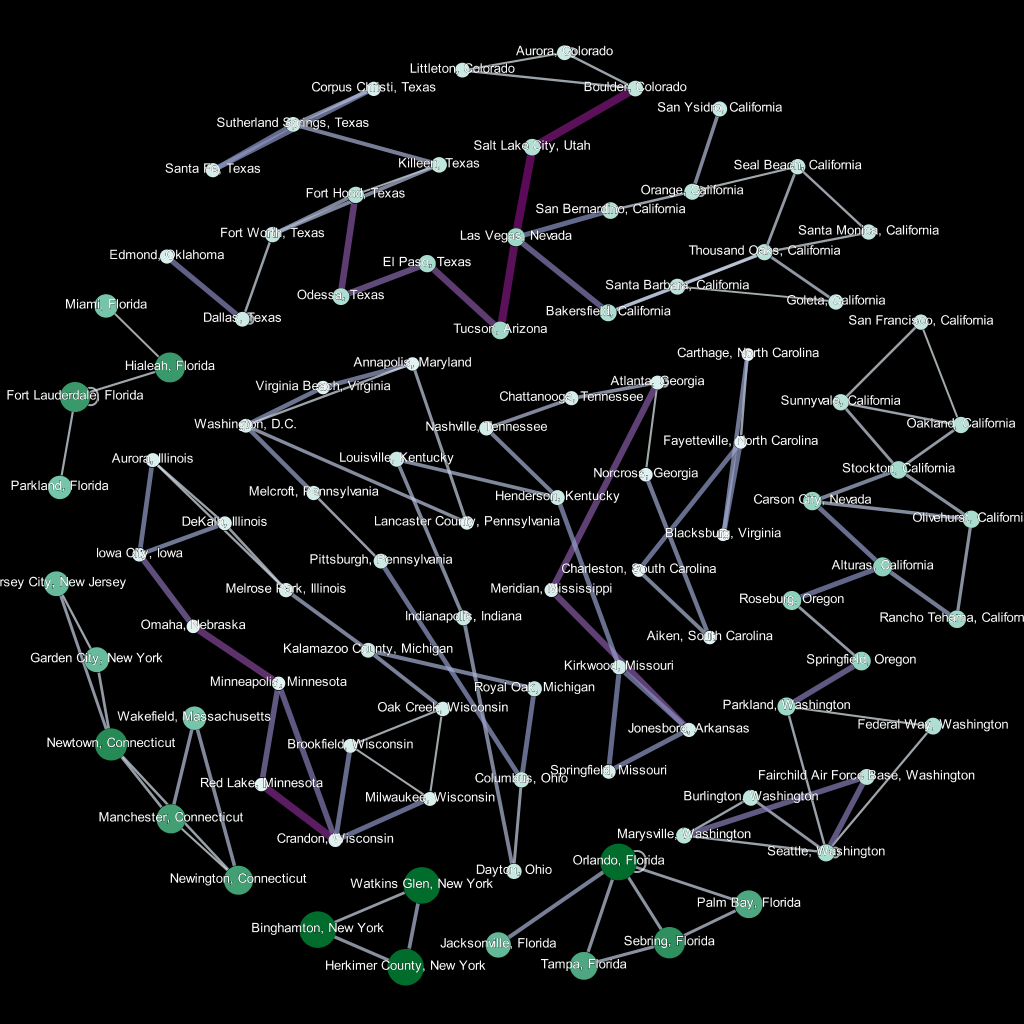

So what does this graph show us? What I did in Gephi was to change the color and size of nodes based on their closeness centrality. Closeness centrality is defined as the inverse distance to all other nodes. Nodes with a high closeness centrality have a lot of influence over a network and can spread info quicker than lower scoring nodes. The way I set this graph up will essentially force shootings that were extremely close to one another to make their own independent clusters, which will make their closeness centrality larger than others.

The edges are weighted by the distance from each node. What the graph shows is that we have a lot of shootings that are geographically far apart, and we also have some that are extremely close together in comparison. Florida is a great example. It has small weights, which means the shootings are relatively close together, and as a result it forms small clusters of shootings, as opposed to one giant one. Whereas places in Texas, which had many shootings, are not as close, likely due to how spread out the state is.


Now we want to create a map of COVID-19 cases and mass shootings for each state so we can visually compare the two graphs and determine if there are any similarities.

In [18]:
# Instantiating an instance of the map using folium
shooter_map = folium.Map(location=[39.29, -76.61])
# Applying the heat to every data point
heat = [[row['latitude'], row['longitude']] for i, row in msi.iterrows()]
# Applying the heat to the map
hm(heat, radius=10).add_to(shooter_map)

In [19]:
# This goes through the latitude and longitude and creates a circle at the specific point on the map

for lat, long in zip(lats, longs):
        folium.Circle((lat, long)).add_to(shooter_map)
# The following code makes the map default out to the correct zoom for all of the datapoints
sw = df[['latitude', 'longitude']].min().values.tolist()
ne = df[['latitude', 'longitude']].max().values.tolist()

In [20]:
# This is a map of all of the mass shootings in our dataset, all we can currently discern is the abstract clustering
# of the shooting themselves. We want a more detailed approach
shooter_map.fit_bounds([sw, ne])
shooter_map

What we want to do next is gather the amount of shootings per state, to do that we are going to parse through the msi locations and create a counter object that acts similar to a hashmap, in that the key is the location, and the value is the number of occurrences. To start that process we will grab all state names from the dataframe by using a regex that only captures the state, not the city.

In [21]:
# We use a regex to filter by state alone, we do not want the city with it
import re

statepattern = re.compile(r'[^,]*$')

# This code loops over the entire list and grabs just the state names
statecount = []

for ele in locs:
    for str in re.findall(statepattern, ele):
        statecount.append(str)

In [22]:
# First we get rid of any null values our regex might have made, then we sort alphabetically

statecount = list(filter(None, statecount))
list.sort(statecount)
states = []

# This is done to get rid of the weird spacing, it just gets rid of whitespace
for str in statecount:
    states.append(str[1:])

states.remove('D.C.') # D.C. is not a state so we remove it from the list

In [23]:
# Here is the counter object that I described earlier, this will be used in the graph

from collections import Counter
statescount = Counter(states)

# This means that New York appeared 4 times in our data set
statescount['New York']

4

In [24]:
# Here I am just grabbing a complete list of the states since the msi does not have a shooting in every state
# If you do not understand what the regex does, I highly encourage you to check out https://regex101.com/ for 
# what that one means, and to test your own

allstates = covid_df['state']
statepattern = re.compile(r'(.*?),')
alls = []
for ele in allstates:
    for str in re.findall(statepattern, ele):
        alls.append(str)

We can iterate through each state in the msi and add the number to a dataframe, this just takes that counter object we made earlier, and gets the results we want in an array. We can then add that array to a dataframe that shows all of the states with how many mass shootings they have had according to our dataset.

In [25]:
# Adding the counter to each state in an array

states = set(states)
shootings = []
for state in alls:
    shootings.append(statescount[state])

In [26]:
# Making a dataframe that contains the mass shootings per state

ms_per_state = pd.DataFrame()
ms_per_state['states'] = np.asarray(alls)
ms_per_state['num of shootings'] = np.asarray(shootings)
ms_per_state['states'] = alls # Have to do this rediculousness for some  reason
ms_per_state['lats'] = covid_df['lats']
ms_per_state['longs'] = covid_df['longs']

In [27]:
ms_per_state.head()

,states,num of shootings,lats,longs
0,Alabama,0,32.318230,-86.902298
1,Alaska,0,66.160507,-153.369141
2,Arizona,1,34.048927,-111.093735
3,Arkansas,1,34.799999,-92.199997
4,California,17,36.778259,-119.417931


In [28]:
# Making another folium map to show the dataframe above

shooter_map = folium.Map(location=[39.29, -76.61])
shooter_map.fit_bounds([sw, ne])

Now that we have the data we want we can finally get to formalizing our maps using different colors to differentiate between the number of shootings. For the three colors I choose blue for 0-1 shootings. This is because many states are between 0-1, which is within margin of error considering many of the states with 0 shootings actually have 1 or two not listed in this dataset. 
 
The next level is the 'intermediate' level of shootings. For this I say anything from 2 to 6 shootings because that is more than what I would consider margin of error, but not a massive cluster considering how large the states are, and the length of the timeline.

The final level is what I would consider 'hot', and that involves anything with 6 or more shootings

In [29]:
color = 'blue'

# Iterating through all of the rows and assinging colors based off of our criteria
for i, row in ms_per_state.iterrows():
    if row['num of shootings'] <= 1:
        color = 'lightblue'
    if row['num of shootings'] > 1 and row['num of shootings'] <= 6:
        color = 'orange'
    if row['num of shootings'] >6:
        color = 'red'
    folium.Marker((ms_per_state['lats'][i], ms_per_state['longs'][i]), popup = ms_per_state['num of shootings'][i], icon=folium.Icon(color=color)).add_to(shooter_map)    
        
        

We now want to create a map of the COVID-19 cases per state, this will also have three levels of severity depending on how many people were infected in each state.

The first level are states with less than 100,000 cases.

The second level are states between 100,000 and 1,000,000 cases

The final level are states with 1,000,000+ infections

I picked these numbers because looking at the data it seemed appropriate. States in the midwest or less populated areas tend to have less than 100,000 cases. Then you have many states that are between 100,000 and 1,000,000. Finally the states with more than a million infections tend to have mega cities which puts them in a class all on their own.

In [30]:
# Making a similar map to show COVID-19 statistics

map_covid = folium.Map(location=[39.29, -76.61])
map_covid.fit_bounds([sw, ne])


color = 'blue'
# We go through each row and change the color of the marker based off of how many infections there are in the state
for i, row in covid_df.iterrows():
    if row['Cases'] < 200000:
        color = 'lightblue'
    if row['Cases'] >= 200000 and row['Cases'] < 1000000:
        color = 'orange'
    if row['Cases'] >= 1000000:
        color = 'red'
    folium.Marker((covid_df['lats'][i], covid_df['longs'][i]), popup = covid_df['Cases'][i], icon=folium.Icon(color=color)).add_to(map_covid)    
        
   

In [31]:
shooter_map

In [32]:
map_covid

If we look at just the map, do mass shootings follow any sort of visual pattern in the way they manifest geographically? It would appear so to some degree. In fact, some states with the largest infection rates also had some of the highest numbers of mass shootings. Furthermore, these areas all contain massive urban areas and are the highest populated states in the US. That does lend credence to the idea that these specific states have a higher chance of infection and mass shootings. However it does not mean that there exists a concrete relationship that mass shootings spread like a virus.

California, Texas, and Florida are the big three that stand out in both maps. Many of the midwestern and northeastern states were less affected by either tragedy. However it is not a perfect match, New york for instance has a fairly low amount of shootings here, but a massive amount of infection cases. That goes against the idea that mass shootings are purely focused around urban areas.

One thing this does not take into account is how many victims died in each shooting. Nevada is orange on the map, but had one of the deadliest shootings in US history. This map is purely based on the number of shootings, not the number of deaths in each one.

So do mass shootings spread to nearby areas? Perhaps, but it does not appear that areas that are geographically close are more at risk if one state has an extreme number of mass shootings. Looking at the states surrounding Texas, most of those states are blue, which means a very low number of shootings there. The vector of transmission for these tragedies is not geographic per se, it is likely based on the airwaves. There is an entire discussion on how the media coverage of these tragedies influences would be perpetrators, but that is not in the scope of this project.

## PART 4: REGRESSION MODELING AND ANALYSIS

#### Question 2: Has the occurrence of mass shootings had a sudden uptick in cases?

An epidemic must have a rapid, unprecedented increase in cases to be called such. Let us assume that there has been a drastic increase. What we are going to do is graph how many shootings per year there was, and then see if there exists an exponential trend, which would confirm our hypothesis. To start, we can make a counter object of the years of mass shootings and then plot it to see if there are any trends that suggest a rapid uptick in cases.

In [33]:
# Reminder of the df we are working with
msi.head()

,index,location,year,fatalities,latitude,longitude
0,0,"Indianapolis, Indiana",2021,8,39.686630,-86.323130
1,1,"Orange, California",2021,4,33.835420,-117.853790
2,2,"Boulder, Colorado",2021,10,39.986961,-105.251168
3,3,"Atlanta, Georgia",2021,8,34.111653,-84.580376
4,4,"Springfield, Missouri",2020,4,37.210432,-93.236860


In [34]:
# Reminder that this gets a count of how many shootings per year there was
test = Counter(msi['year'])

# We now want to make a range from 1982 to 2021 with the count of each shooting

years = [*range(1982,2022)]
shootings = []

for year in years:
    shootings.append(test[year])

Text(0, 0.5, 'Number of Shootings')

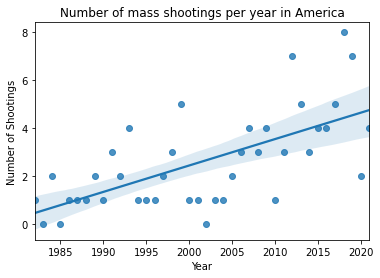

In [35]:
# Our x is going to be the years, and the y is going to be the number of shootings

plot = sns.regplot(x=years, y=shootings).set_title('Number of mass shootings per year in America')
plt.xlabel("Year")
plt.ylabel("Number of Shootings")

What can we see about this plot? First, it is messy, there are many years where there are spikes and lulls in the violence. However looking at it big picture, it does appear to have an uptrend over time. However we have to think, is there correlation or causation? Because there are many factors that determine whether or not a shooting takes place, we cannot just generalize it to the year and claim that it is a foolproof model for the future. Furthermore because the spread is so wide and we do not have available reasoning why it is, we cannot easily apply a function to fit the model perfectly. 

All of this being said, for the purposes of this project we are going with what we have. So is this indicative of an epidemic? I would argue no, it is not. Epidemics are supposed to have a clear exponential growth in their case number, however we can see here that the number of mass shootings does not appear to grow like that. It does indeed increase over time, of that there is no dispute. Still, it does not expand as much as the rhetoric would make one think, the 90's were a turbulent time on their own just by looking at this graph. Looking at what the CDC says, an epidemic typically has a 'steep upslope and a more gradual downslope'. Unfortunately we do not have a downslope yet, but looking at the upslope does not yield conclusive data that it is exponential in the short term. The chart does not have a clear linearity to it however, so it would be dishonest to completely dismiss the idea that there is rapid growth in the number of shootings. It is not clear to call it either way, the data is just too spread out with this data set.

What can we do with this? We discussed earlier that this is an extreme simplification of events, and that there are thousands of factors that go into play here. However, because it is interesting, let us create a linear model to describe the data, and use it to predict what we might see later this decade. Do not take this as law, as mentioned above this is not a good fit for linear regression, which we can use as a teaching moment.

There are several assumptions for modeling that have to be considered when using linear regression.
1. The relationship between X and Y exists and is linear.
2. Observations are independent.
3. For all values of X, Y is a normal distribution. (Does not really apply to us for this graph)
4. The residuals have an equal variance.

To predict anything in the future requires us to create a model. The best way to do this is to split the data into testing and training data. The training data is used exclusively to train the model, the testing data is used just to test the model once it is made. We do this because when you train a model on the entire dataset, then it skews it because it already knows all of the data points. You want to be able to test it on points it hasn't learned of to see if it is at all accurate.

In [36]:
# We will now create a linear model using sklearn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

years = np.asarray(years)
# Creating the 4 testing and training variables, test_size of .3 means the data is 30% test, 70% train
xtrain, xtest, ytrain, ytest = train_test_split(years, shootings, test_size = .3)
# Creating the model
model = LinearRegression()
# Fitting the model to the training data (reshape is needed for this function)
model.fit(xtrain.reshape(-1, 1), ytrain)
# Creating a prediction based off of the testing data
prediction = model.predict(xtest.reshape(-1, 1))

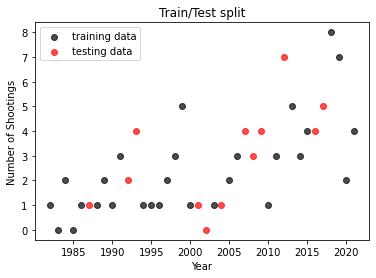

In [37]:
# Graphing the training/testing data

plt.scatter(xtrain, ytrain, label = 'training data', color = 'black', alpha = .7)
plt.scatter(xtest, ytest, label = 'testing data', color= 'r', alpha = .7)
plt.legend()
plt.title('Train/Test split')
plt.xlabel("Year")
plt.ylabel("Number of Shootings")
plt.show()

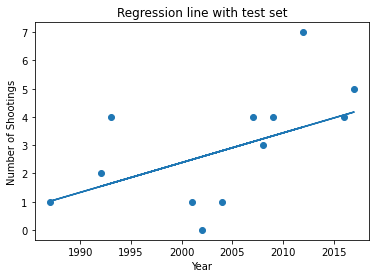

In [38]:
plt.plot(xtest, prediction)
plt.scatter(xtest, ytest)
plt.title('Regression line with test set')
plt.xlabel("Year")
plt.ylabel("Number of Shootings")
plt.show()

We can observe that one of the shortcomings with this method is that we simply do not have many data points. That means that any one point can have greater influence on the model than it otherwise should have. This is a great example of something that should not be modeled this way, the data set is just too complex and has too few data points.

In [39]:
# When you make a model, depending on how you do it, you can have one or more coefficients. The first one in this 
# case is the slope of our line

coefficient = model.coef_[0]
score = model.score(xtest.reshape(-1, 1), ytest)
# Grabbing the y intercept
intercept = model.intercept_
print(f'coefficient/slope: {coefficient}, y-Intercept: {intercept}, Score: {score}')

coefficient/slope: 0.10543206540098637, y-Intercept: -208.48074454428746, Score: 0.3228918967590092


The score is not great. Because it relies on such few data points in a very wide spread graph; it is not going to be reliable. The intercept is really low because we are starting in 1982 (function starts at 0), and the coefficient of roughly 1/10 implies that for every year that goes by, the number of shootings increases by .1 shootings. Of course you cannot split a shooting like that, but because it's over such a long period of time it makes some sense. If the average amount of mass shootings 30 years ago was 2 per year, then saying the average of 2020 is roughly 5 per year matches the data. This is an extremely simple model, so take it with a grain of salt. Because we are comparing data from such a long time ago we miss trends that are more recent. For instance, if in the last five years there really was a drastic spike, we would not be able to model it because the rest of the graph would dominate.

That brings me to the next major point of mass shootings: classification. This chart could look WILDLY different depending on how you classify a mass shooting. I am being up front and gave you the criteria in the beginning. However there is no official standard that everyone agrees upon. You can find many databases that list anything that involved 2 deaths in a mass shooting. When someone tells you about a rapid increase of these tragedies you must know by what metric they are measuring, because it is very easy to lie with statistics by changing the meaning of words (i.e what the definition of a mass shooting is). That is not unique to this dataset, anything could be misrepresented like that. It is up to you to do your research and ask the right questions to make sure the data is being represented in an honest light.

In [40]:
# Lets take some residuals, this is one way to see if our data should be modeled using a linear regression. A 
# residual is the actual value - the predicted value.

# Predicting based off of all of the years in the dataset
prediction = model.predict(years.reshape(-1, 1))
residuals = []

# Looping through the actuals and predictions and subtracting them
for x,y in zip(shootings, prediction):
    residuals.append(x-y)

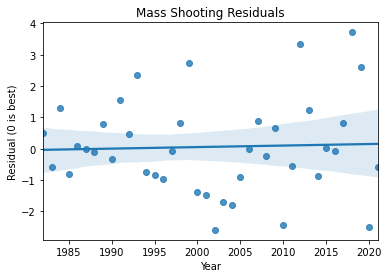

In [41]:
# We can observe that the residuals do fan out in a triangle, which is not what you want to see. Ideally 
# it forms a sort of rectangle, which means that the residuals are somewhat even. What this means is that we used 
# a linear regression on something that needed a model with a little more nuance

sns.regplot(x = years, y = residuals).set_title('Mass Shooting Residuals')
plt.ylabel("Residual (0 is best)")
plt.xlabel("Year")
plt.show()

Our residuals are all over the place, which suggests that our linear model may capture the general trend of the data, but cannot be used to reliably predict future incidents because the residuals fan out.

We are now going to switch gears and look at all of the gun deaths in America to see if there are any similarities to what an epidemic would look like on a chart in terms of exponential growth. Afterwards we are going to compare it to some stats from COVID-19 to see if they are similar in any way.

Let us take another quick look at how easily data can be misrepresented. This from the firearm fatalities dataframe, and we are graphing the deaths per year since 1999. I will first plot the data in a line graph with the origin not at zero, and then a bar chart with the origin at 0.

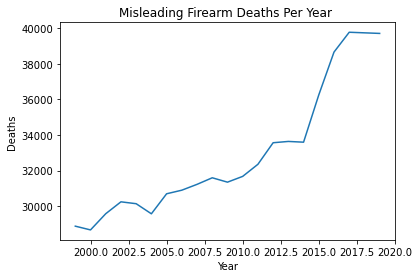

In [42]:
plt.plot(firearmfatalities['Year'], firearmfatalities['Deaths'])
plt.title('Misleading Firearm Deaths Per Year ')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.show()

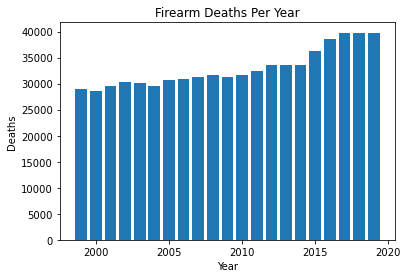

In [43]:
plt.bar(firearmfatalities['Year'], firearmfatalities['Deaths'])
plt.title('Firearm Deaths Per Year')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.show()

If you were to look just at what the top graph was it could be so easy to say that violence has been escalating in an obvious exponential fashion. What the data shows however is a linear increase since the year 1999, with a small spike starting in 2015.

Below we are going to graph all of the United States' COVID-19 deaths per week.

In [44]:
# Reminder of the df we are working with

covid_deaths_week.head()

,Start Date,State,Total Deaths,COVID-19 Deaths
0,12/29/2019,United States,60171.0,1.0
1,01/05/2020,United States,60726.0,0.0
2,01/12/2020,United States,59353.0,4.0
3,01/19/2020,United States,59154.0,2.0
4,01/26/2020,United States,58822.0,0.0


In [45]:
# The first 60 rows in the dataframe are specifically for the group we want, which is the US as a whole

USdeaths = covid_deaths_week[0:60]

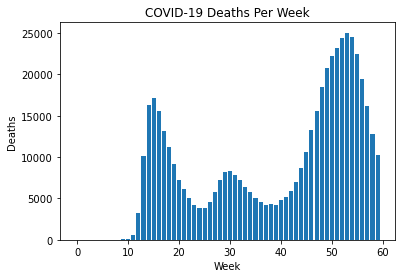

In [46]:
# I am using a list from 0 to 60 because it displays on the graph better, and you cannot input strings
# as the x axis

plt.bar(list(range(0, 60)), USdeaths['COVID-19 Deaths'])
plt.title('COVID-19 Deaths Per Week')
plt.xlabel('Week')
plt.ylabel('Deaths')
plt.show()

Comparing firearm deaths with COVID-19 deaths we get two very different behaving graphs. There are several reasons for this, first, firearm data goes back 20 years, it is a much longer time span than the COVID-19 data, which is only about 1.5 years. Second, gun deaths have not been increasing in the way an epidemic does. You could fit a very nice linear regression to that firearm graph, you absolutely could not with the COVID-19 deaths. That is a perfect example of the limitations of linear regressions, as you would need a high degree polynomial to get a good match for it. That being said, one of the benefits of linear regressions is there simplicity and efficiency. Matching exponential curves however is not one of them.

To prove it to you, I am going to make linear regression models for each dataset, then calculate the score of each one to see how good the models are. The score is a measurement of the error of a model on a given dataset, the higher the score, the better the model.

In [47]:
x = np.asarray(firearmfatalities['Year'])
y = np.asarray(firearmfatalities['Deaths'])

# Creating the 4 testing and training variables
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = .3)
# Creating the model
gun_death_model = LinearRegression()
# Fitting the model to the training data (reshape is needed for this function)
gun_death_model.fit(xtrain.reshape(-1, 1), ytrain)
# Creating a prediction based off of the testing data
prediction = gun_death_model.predict(xtest.reshape(-1, 1))

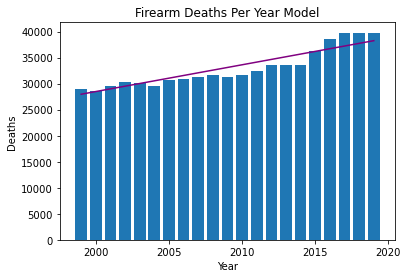

In [48]:
# Linear regression in purple
gun_death_prediction = gun_death_model.predict(x.reshape(-1, 1))

plt.plot(x, gun_death_prediction, color = 'purple')
plt.bar(x, y)
plt.title('Firearm Deaths Per Year Model')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.show()

In [49]:
coefficient = gun_death_model.coef_[0]
score = gun_death_model.score(x.reshape(-1, 1), y)
# Grabbing the y intercept
intercept = gun_death_model.intercept_
print(f'coefficient/slope: {coefficient}, y-Intercept: {intercept}, Score: {score}')

coefficient/slope: 514.248213304013, y-Intercept: -1000023.3768554147, Score: 0.8567925625691705


Let us try that with the COVID-19 data.

In [50]:
# An array of len 60 that represents the first week to the last

str_dates = np.asarray(USdeaths['Start Date'])
weeks = list(range(0, 60))


In [51]:
x = np.asarray(weeks)
y = np.asarray(USdeaths['COVID-19 Deaths'])

# Creating the 4 testing and training variables
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = .3)
# Creating the model
covid_death_model = LinearRegression()
# Fitting the model to the training data (reshape is needed for this function)
covid_death_model.fit(xtrain.reshape(-1, 1), ytrain)
# Creating a prediction based off of the testing data
prediction = covid_death_model.predict(xtest.reshape(-1, 1))

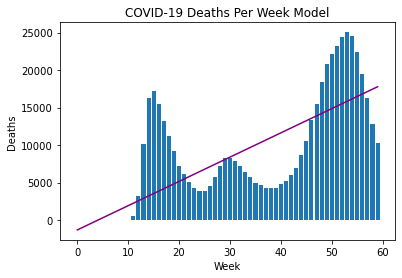

In [52]:
covid_prediction = covid_death_model.predict(x.reshape(-1, 1))

plt.plot(x, covid_prediction, color = 'purple')
plt.bar(x, y)
plt.title('COVID-19 Deaths Per Week Model')
plt.xlabel('Week')
plt.ylabel('Deaths')
plt.show()

In [53]:
coefficient = covid_death_model.coef_[0]
score = covid_death_model.score(x.reshape(-1, 1), y)
# Grabbing the y intercept
intercept = covid_death_model.intercept_
print(f'coefficient/slope: {coefficient}, y-Intercept: {intercept}, Score: {score}')

coefficient/slope: 323.4552087097482, y-Intercept: -1308.4656113922738, Score: 0.4811743245621273


It should be obvious from these two plots, and the scores of each model, that the linear model works for firearm deaths, and it does not work for COVID-19 deaths. What this means is that one has exponential growth and decay, and the other does not. Furthermore it means that the amount of firearm deaths in America does not appear to be growing in the manner befitting of an epidemic, as that would require explosive growth in a short time.

But what can we do to give a more fair comparison? Change the timetable. We are comparing sets from vastly different time differences, so let us look at only the last few years of firearm fatalities to get a better look at the recent activity.

In [54]:
recent_firearm_fatalities = firearmfatalities[firearmfatalities['Year']>=2015]
recent_firearm_fatalities.head()

,Year,Deaths
16,2015.0,36252
17,2016.0,38658
18,2017.0,39773
19,2018.0,39740
20,2019.0,39707


In [55]:
x = np.asarray(recent_firearm_fatalities['Year'])
y = np.asarray(recent_firearm_fatalities['Deaths'])
# Creating the model
recent_gun_death_model = LinearRegression()
# Fitting the model to the training data (reshape is needed for this function)
recent_gun_death_model.fit(x.reshape(-1, 1), y)
# Creating a prediction based off of the testing data
recent_gun_death_prediction = recent_gun_death_model.predict(x.reshape(-1, 1))

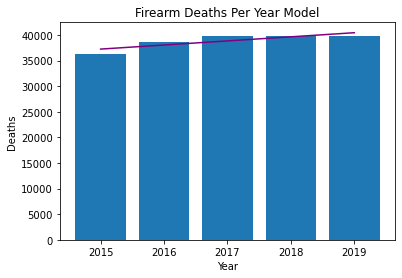

In [56]:
plt.plot(x, recent_gun_death_prediction, color = 'purple')
plt.bar(x, y)
plt.title('Firearm Deaths Per Year Model')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.show()

In [57]:
coefficient = recent_gun_death_model.coef_[0]
score = recent_gun_death_model.score(x.reshape(-1,1), y)
# Grabbing the y intercept
intercept = covid_death_model.intercept_
print(f'coefficient/slope: {coefficient}, y-Intercept: {intercept}, Score: {score}')

coefficient/slope: 799.1999999999999, y-Intercept: -1308.4656113922738, Score: 0.6971360389676797


Based on just the last five years we do get a larger slope than the entire dataset did, however it still is not many times higher, and does appear to fit to a linear regression much better than the COVID-19 set. Furthermore it appears that the last few years actually leveled off. That being said we do not have access to the most recent data from the CDC, so we cannot test 2020-2021.

#### Question 3: What are the fatality rates of COVID-19 and firearms, and how do they compare?

For this we are not going to compare raw numbers of how many people died from covid to how many people died from firearms, we can already see that from the graphs above exponentially more people died from covid than firearms in the last year. That being said, we can look at the mortality rate for if someone was shot, what are their chances of survival? Then we can compare that to the average fatality rate of covid and see what we can see.

Since there are no easily available resources that show all emergency room visits for firearm related injuries, I will be using numbers from a paper published in JAMA Internal Medicine linked here.
https://jamanetwork.com/journals/jamainternalmedicine/article-abstract/2773788

The abstract is that from 2009-2017 an average of 120,232 firearm injuries occur each year. For our purposes we are not going to differentiate between suicides and other motives. For our first graph we did not, so it makes sense to bring them in here as well. Just note that this is a simplification, fatality rate for suicides is of course much higher than other forms.

In [58]:
# To calculate this, first we need to know what the average deaths were per year in that time span for firearms.
# We can then compare it to the national fatality average of COVID-19.

# We need the average deaths per year from 2009-2017
# To get this we can collect rows where they meet our criteria for the year

deathtoll = 0

for index, row in firearmfatalities.iterrows():
    if row['Year'] >= 2009 and row['Year'] <= 2017:
        deathtoll += firearmfatalities['Deaths'][index]

print(f'The total deathtoll from 2009 to 2017 is: {deathtoll}')

The total deathtoll from 2009 to 2017 is: 310846


In [59]:
# Now that we have the total deaths for that time period, we need to sum up the total injuries, then divide them
# into the fatalities to get the rate

total_injuries = 9*120232

fatality_rate_firearm = round((deathtoll / total_injuries) * 100, 2)

We are averaging the injuries per year, so this number is not exact but it is close. The average death rate, including suicides, is approximately 28.73%. 

According to https://www.worldometers.info/coronavirus/country/us/ the total US deathrate is 2%. Of course this does not take into account age or health conditions. That is out of scope of this project, so we are just going to compare the raw number.

The firearm fatality rate is almost 30%, meanwhile COVID-19 has an average fatality rate of 2%. What this tells us is that IF you were in a firearm related incident you would be more likely to perish from than than COVID-19 on average. That is taking no motives, nor conditions, into account. Please understand that this is a simplified version of events, being over the age of 70 for example would greatly increase your chances of dying from COVID-19. 

The point of this question was to simply figure out how deadly these firearm incidents are in comparison to a pandemic. By figuring out the death rate we can say that it appears to be much more dangerous to get shot than to get COVID-19 on average. This does lend support to saying that gun violence is physically deadlier than COVID-19.

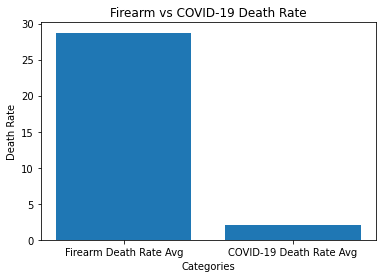

In [60]:
rates = [fatality_rate_firearm, 2]
afflictions = ['Firearm Death Rate Avg', 'COVID-19 Death Rate Avg']
plt.bar(afflictions, rates)
plt.title('Firearm vs COVID-19 Death Rate')
plt.xlabel('Categories')
plt.ylabel('Death Rate')
plt.show()

## PART 5: Conclusion

What we have learned:
1. Gun violence has an extremely high mortality rate when compared to COVID-19, a world wide pandemic.
2. Gun violence has been steadily increasing for the past 2 decades.
3. It has not been exponentially increasing the way an epidemic does.
4. Mass shootings do have clusters, but how they spread is not likely due to close proximity to other shootings specifically.

While there does appear to be some similarity with an epidemic in the way mass shootings are clustered, I would argue that they, nor overall gun violence is an 'epidemic'. Gun violence does not meet the timetable or the rate of increase like an epidemic does. It is a very major problem, however it is my opinion that using that language to describe it is inaccurate. I would argue that something along the lines of 'it is an ever present issue that steadily worsens,' would be more accurate. The fatality rate when the shootings do happen is large, and they appear to be steadily increasing over time, which is cause for concern. Of course this is a very basic analysis, the hope is that you learned more about the data science pipeline, and realized that it takes a lot of nuance to properly report statistics. The main takeaway from all of this is to verify the sources and methods people use for representing data, if they do not disclose the metrics by which they measure, then there is a chance they are being dishonest.